# 1. Imports

In [1]:
import pandas as pd
import numpy  as np
import math
from   datetime import timedelta
from datetime   import datetime
from   IPython.display import Image


import warnings as wrg

import matplotlib.pyplot as plt
from   matplotlib.gridspec import GridSpec
import seaborn as sns
from SRLib.Utilities import graph

from statsmodels.stats import api as sms
from scipy.stats       import chi2_contingency 

# 2. Help Functions | Settings

In [2]:
wrg.filterwarnings('ignore')


# 3.Load data

In [3]:
data_raw = pd.read_csv( '../data/ab_data.csv' )

In [4]:
data_raw.timestamp = pd.to_datetime(data_raw.timestamp)

## 3.1 Initial conversion

In [5]:
data_raw.timestamp = pd.to_datetime( data_raw.timestamp )

# 4. EDA

In [6]:
display( data_raw.head() )
display( data_raw.describe().T )
display( data_raw[['group', 'landing_page']].describe().T )
display( f'Conjunto contendo {data_raw.shape[0]} linhas e {data_raw.shape[1]} colunas' )

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


,count,mean,std,min,25%,50%,75%,max
user_id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0


,count,unique,top,freq
group,294478,2,treatment,147276
landing_page,294478,2,old_page,147239


'Conjunto contendo 294478 linhas e 5 colunas'

In [7]:
### Conferência das flags do Teste A
data_raw[['user_id', 'group', 'landing_page']].groupby( by=['group', 'landing_page'] ).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


In [8]:
duplicated = data_raw[['user_id', 'group']].groupby( 'user_id' ).count().reset_index().query( 'group > 1' )['user_id']
df = data_raw[~data_raw['user_id'].isin( duplicated )]

Tamanho amostral: 286690


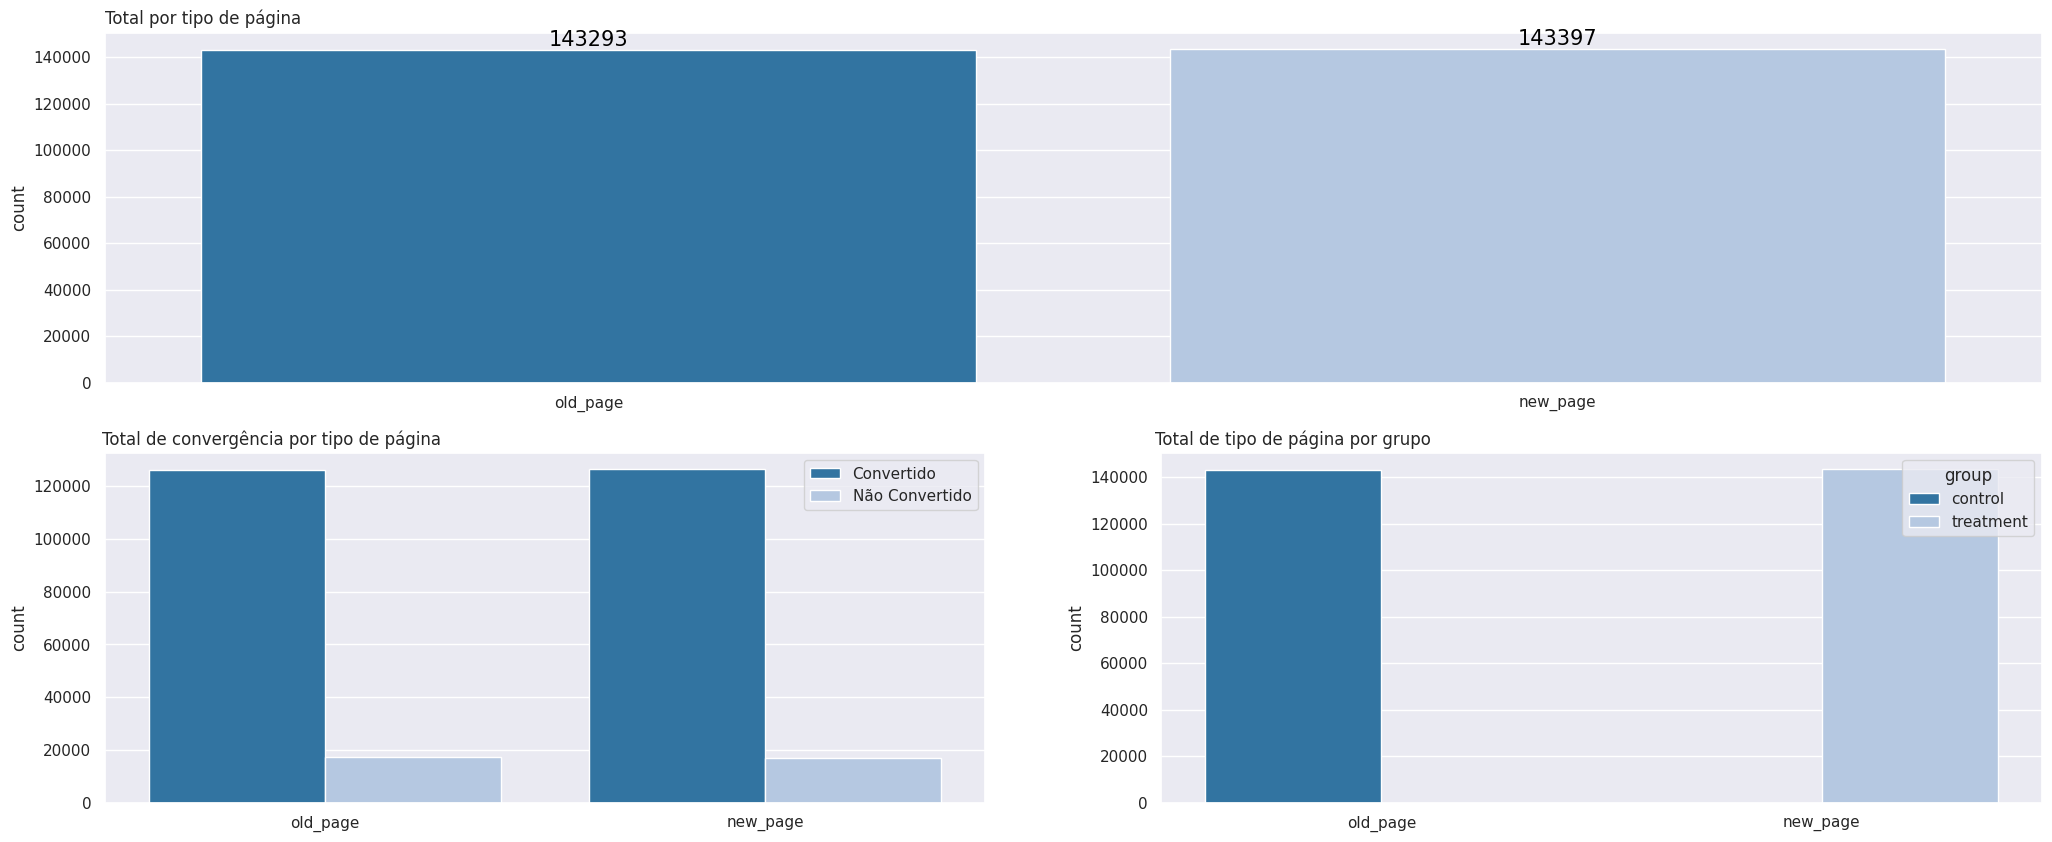

In [17]:
from tempfile import tempdir


sns.set( rc={'figure.figsize' : (25,10)} )
spec = GridSpec(2,2)

#First chart
plt.subplot( spec[0,:] )
ax = sns.countplot(
    data    = df,
    x       = 'landing_page',
    palette = 'tab20'
);
graph.plot_values_vbar( ax )
plt.title( 'Total por tipo de página', x = 0.051 );
plt.xlabel( None );

#Second chart
plt.subplot( spec[1,0] )
ax = sns.countplot(
    data    = df,
    x       = 'landing_page',
    hue     = 'converted',
    palette = 'tab20'
);
plt.legend( ['Convertido', 'Não Convertido'] );
plt.title( 'Total de convergência por tipo de página', x = 0.19 );
plt.xlabel( None );


#Third chart
plt.subplot( spec[1,1] )
ax = sns.countplot(
    data    = df,
    x       = 'landing_page',
    hue     = 'group',
    palette = 'tab20'
);
plt.title( 'Total de tipo de página por grupo', x = 0.15 );
plt.xlabel( None );

print(f'Tamanho amostral: {df.shape[0]}')


# 5. Design de Experimentos

## 5.1 Formulação de hipóteses

## 5.2 Parâmetros do experimento

In [27]:
### Nível de Confiança
n_conf    = 0.95
### Nível de Significância
n_sign    = 0.05

# Proporção da página atual e da nova página
p1 = 0.13
p2 = 0.15

### Poder estatístico
power  = 0.80

### Tamanho do efeito
tam_efeito = sms.proportion_effectsize( p1, p2 )
display( f'Valor do tamanho do efeito calculado:  {tam_efeito}' )

'Valor do tamanho do efeito calculado:  -0.0576728617308947'

In [28]:
#Tamanho da amostra
sample_n =sms.NormalIndPower().solve_power(
    effect_size = tam_efeito,
    power       = power,
    alpha       = n_sign,
)
sample_n = math.ceil( sample_n )
display( f'O tamanho da amostra necessária de cada grupo (controle e tratamento) é: {sample_n}' )
display( f'Sendo necessária uma amostra total de: {2*sample_n}' )

'O tamanho da amostra necessária de cada grupo (controle e tratamento) é: 4720'

'Sendo necessária uma amostra total de: 9440'

##### Funil quanto ao envio e resposta aos e-mails

In [20]:
convertion_rate = 0.10 #Referente a taxa de resposta aos e-mails enviados
tot_email       = math.ceil( ( 2*sample_n / convertion_rate ) )
print(f'Será necessário o envio de {tot_email} e-mails ')

Será necessário o envio de 94400 e-mails 


#### Cálculo da média de clientes a serem atingidos e tempo médio

In [21]:
from datetime import datetime


temp = data_raw[['user_id', 'timestamp']]
temp['day'] = temp.timestamp.dt.day
temp = temp[['day', 'user_id']].groupby('day').count().reset_index()
media = math.ceil( temp.user_id.mean() )
display( f'Média de acessos diários: {media}, sendo necessários ~ {math.ceil(tot_email / media)} dias para atingir a meta de envio de e-maisl' )



'Média de acessos diários: 12804, sendo necessários ~ 8 dias para atingir a meta de envio de e-maisl'

---

- Como será preciso de uma amostra de 1246 por grupo (2492 no total) e a taxa de conversão é de 13%, será necessário aproximadamente 29.318 envios para atingir a meta;
- Sendo necessários assim, 3 dias para atingir todas as amostras necessárias.

# 6. Aplicação do modelo

    H0 = A conversão da página é de 13%
    H1 = A conversão da nova página é diferente de 13%

## 6.1 Preparação dos dados

In [121]:
### Preparação mínima dos dados
# Primeiro, serão excluídos todos os usuários que tiveram contato com ambas as páginas (garantindo assim a independência das amostras analisadas)
# !Passo já cumprido na EDA deste mesmo documento. Sendo que os dados filtrados foram salvos em 'df'.
print( '# Preparação dos dados: ' )
print( f'São {df.shape[0]} linhas e {df.shape[1]} colunas restantes de um universo inicial de {data_raw.shape[0]} linhas' )
print( '--' )

### Amostragem
#Grupo controle
df_control = df[df['group'] == 'control'].sample( sample_n, random_state = 42 )
#Grupo tratamento
df_treatment = df[df['group'] == 'treatment'].sample( sample_n, random_state = 42 )
print( '# Amostragem dos dados:' )
print( f'Grupo de tratamento e controle contendo respectivamente {df_control.shape[0]} e {df_treatment.shape[0]} linas.' )
print( '--' )

### Cálculo da taxa de conversão
#Grupo controle
converted = df_control.loc[df_control['converted'] == 1, 'converted'].sum()
visit = len( df_control )
conversion_rate_control = ( converted/visit )
#Grupo tratamento
converted = df_treatment.loc[df_treatment['converted'] == 1, 'converted'].sum()
visit = len( df_treatment )
conversion_rate_treatment = ( converted/visit )
print( '# Taxa de conversão das páginas: ' )
print( f'Taxa de conversão do grupo controle: {conversion_rate_control:.4}' )
print( f'Taxa de conversão do grupo tratamento: {conversion_rate_treatment:.4}' )

### Concatenação dos grupos 
df_ab = pd.concat( [df_control, df_treatment] )

# Preparação dos dados: 
São 286690 linhas e 5 colunas restantes de um universo inicial de 294478 linhas
--
# Amostragem dos dados:
Grupo de tratamento e controle contendo respectivamente 4720 e 4720 linas.
--
# Taxa de conversão das páginas: 
Taxa de conversão do grupo controle: 0.1155
Taxa de conversão do grupo tratamento: 0.129


## 6.2 Seleção do modelo

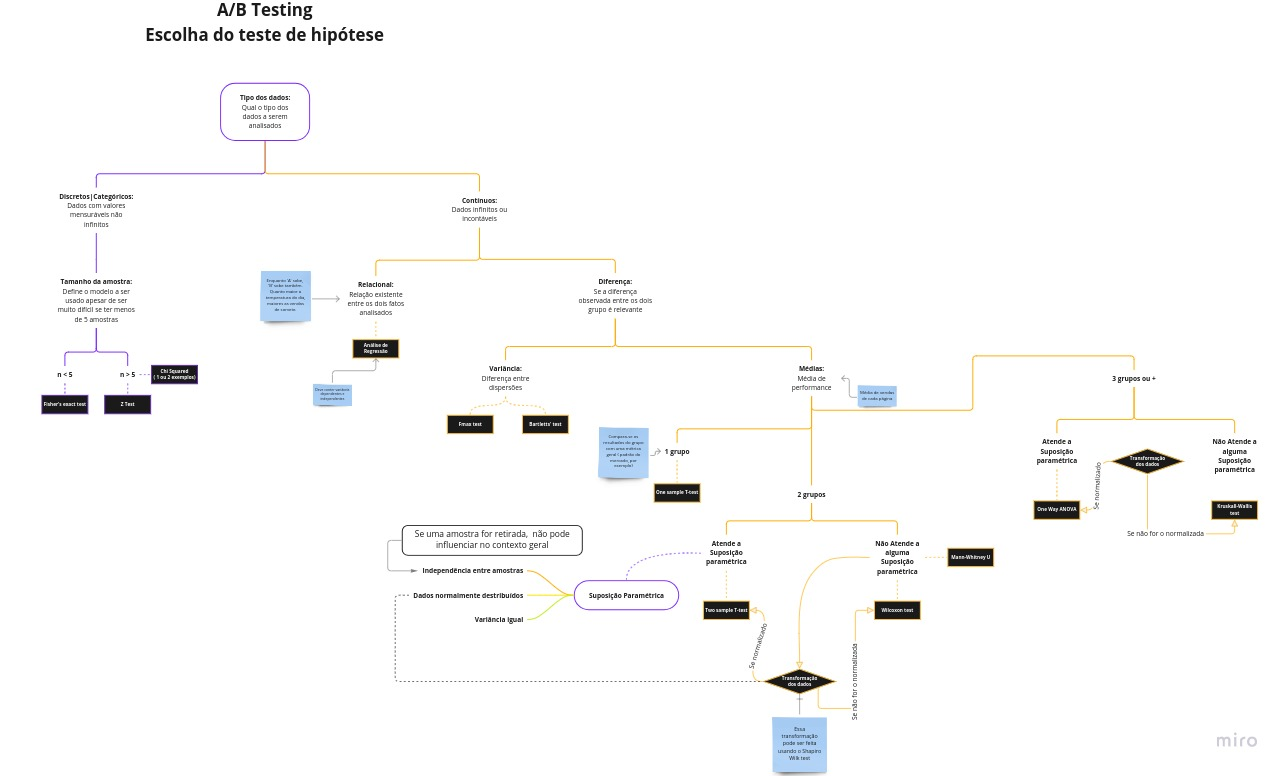

In [50]:
Image( '../img/AB_select_model.jpg' )

    - Tipo de dados: Discreto
    - Tamanho da amostra: > 5 (Maior que 5)   
    - - Teste Inferência: Chi Squared

## 6.3 Aplicação do modelo

In [208]:
### Definindo alpha
alpha = n_sign

### Pivotando os dados para que seham aceitos pelo modelo 
df_table = df_ab[['group', 'converted']].groupby( 'group' ).agg( {'converted' : ['sum', 'count']} )
df_table.columns = ['converted', 'total']
df_table_antes = df_table.copy()
### Aplicação do modelo
chi_val, pval, dof, expeted = chi2_contingency( df_table_antes )

### Testando hipóteses
if pval < alpha:
    print( 'Hipótese nula (H0) Rejeitada' )
else:
    print( 'Impossível rejeitar hipótese nula (H0) ' )   


Impossível rejeitar hipótese nula (H0) 


In [209]:
df_table['not_converted'] = df_table['total'] - df_table['converted']
df_table.drop(columns= 'total', inplace=True)
chi_val, pval, dof, expeted = chi2_contingency( df_table )

### Testando hipóteses
if pval < alpha:
    print( 'Hipótese nula (H0) Rejeitada' )
else:
    print( 'Impossível rejeitar hipótese nula (H0) ' )   

Hipótese nula (H0) Rejeitada


In [205]:
display(df_table_antes)
display(df_table)

,converted,total
group,,
control,545,4720
treatment,609,4720


,converted,not_converted
group,,
control,545,4175
treatment,609,4111


# 7 Conclusão

In [177]:
###Valor do produto
product_val = 4500
### Conversão dos valores de timestamp para dados menos granulares
df_aux = df.copy()
df_aux['timestamp'] = df_aux['timestamp'].apply( lambda x: x.strftime( '%Y-%m-%d' ) )

In [178]:
#Current GMV (Gross margin value -- Valor da margem bruta)
df_aux1 = df_aux[['user_id', 'timestamp']].groupby( 'timestamp' ).count().reset_index()
df_aux1['current_purchases'] = np.ceil( df_aux1['user_id'] * conversion_rate_control )
df_aux1['current_GMV'] = df_aux1['current_purchases'] * product_val

current_gmv = df_aux1['current_GMV'].sum()

#Current GMV (Gross margin value -- Valor da margem bruta)
df_aux2 = df_aux[['user_id', 'timestamp']].groupby( 'timestamp' ).count().reset_index()
df_aux2['expected_purchases'] = np.ceil( df_aux2['user_id'] * conversion_rate_treatment )
df_aux2['expected_GMV'] = df_aux2['expected_purchases'] * product_val

expeted_gmv = df_aux2['expected_GMV'].sum()

lift = 100 * ( expeted_gmv - current_gmv ) / current_gmv 
abs_lift = expeted_gmv - current_gmv

In [210]:
print( f'GMV atual de     {current_gmv} com a taxa de conversão do grupo controle.' )
print( f'GMV esperado de {expeted_gmv} com a taxa de conversão do grupo controle.' )
print( f'Abs lift: {abs_lift}' )
print( f'Com um lift de : {lift} %' )

GMV atual de     149017500.0 com a taxa de conversão do grupo controle.
GMV esperado de 166513500.0 com a taxa de conversão do grupo controle.
Abs lift: 17496000.0
Com um lift de : 11.740902914087272 %


In [181]:
(conversion_rate_treatment - conversion_rate_control) * 100

1.3559322033898313